In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np

In [2]:
cols = ["arch", "activation", "attack", "iterations", "eps 2", "eps 4", "eps 6", "eps 8", "eps 10", "SROCC"]
data = pd.read_csv("rs/results_resnet50.csv", header=0, usecols=cols)

In [3]:
data.sample(5, random_state=0)

,arch,activation,attack,iterations,eps 2,eps 4,eps 6,eps 8,eps 10,SROCC
26,resnet50-Linearity,gelu,IFGSM,3,1.405632,1.626508,1.572590,1.371142,1.176544,0.905415
84,debiasedresnet50-Linearity+prune=0.1pls,elu,IFGSM,1,0.197423,0.160884,0.123395,0.090934,0.062622,0.905012
2,resnet50-Linearity,silu,IFGSM,1,0.259757,0.238187,0.190764,0.139551,0.088635,0.897968
55,resnet50-Linearity,relu_gelu,IFGSM,1,0.337678,0.316484,0.270371,0.221533,0.172357,0.899888
68,resnet50-Linearity-gabor,relu,IFGSM,1,0.050354,0.073940,0.087628,0.097088,0.104434,0.629334


In [4]:
fsilu_data = data[(data["arch"]=="resnet50-Linearity")&(data["activation"]=="Fsilu")].loc[:,"eps 2": "eps 10"].values
print(fsilu_data[0][0],fsilu_data[-1])

0.163610402542497 [0.97357313 1.26601247 1.30603955 1.22152177 1.11837141]


In [7]:
baseline = [('resnet50-Linearity', 'relu')]
group_wd = [
    ("resnet18-Linearity", "relu"), 
    ("resnet34-Linearity", "relu"), 
    ("resnet50-Linearity", "relu"), 
    ("wideresnet50-Linearity", "relu")
]
group_activation = [
    ("resnet50-Linearity", "relu"), 
    ("resnet50-Linearity", "silu"), 
    ("resnet50-Linearity", "relu_silu"),
    ("resnet50-Linearity", "Frelu_silu"),
    ("resnet50-Linearity", "relu_elu"),
    ("resnet50-Linearity", "Frelu_elu"),
    ("resnet50-Linearity", "relu_gelu"),
    ("resnet50-Linearity", "Fsilu"),
    ("resnet50-Linearity", "elu"),
    ("resnet50-Linearity", "gelu"),
    ("resnet50-Linearity", "Fgelu"),
    ("resnet50-Linearity", "Felu") 
]
group_pruning = [
    ("resnet50-Linearity+prune=0.1l1", "relu"),
    ("resnet50-Linearity+prune=0.1l2", "relu"), 
    ("resnet50-Linearity+prune=0.1pls", "Felu")
]
group_special = [
    ("resnet50-Linearity", "relu"),
    ("advresnet50-Linearity","relu"),
    ("wideresnet50-Linearity", "relu"),
    ("vonenet50-Linearity", "relu"),
    ("textureresnet50-Linearity","relu"), 
    ("shaperesnet50-Linearity","relu"), 
    ("debiasedresnet50-Linearity","relu")
]

group_combinations = [
    ("debiasedresnet50-Linearity+prune=0.1pls", "relu"), 
    ("debiasedresnet50-Linearity+prune=0.1pls", "elu"), 
    ("debiasedresnet50-Linearity", "elu"), 
    ("resnet50-Linearity+prune=0.1pls", "Felu"), 
    ("resnet50-Linearity+prune=0.1pls", "silu"), 
    ("resnet50-Linearity", "relu"), 
    ("resnet50-Linearity-noise", "Felu")
]


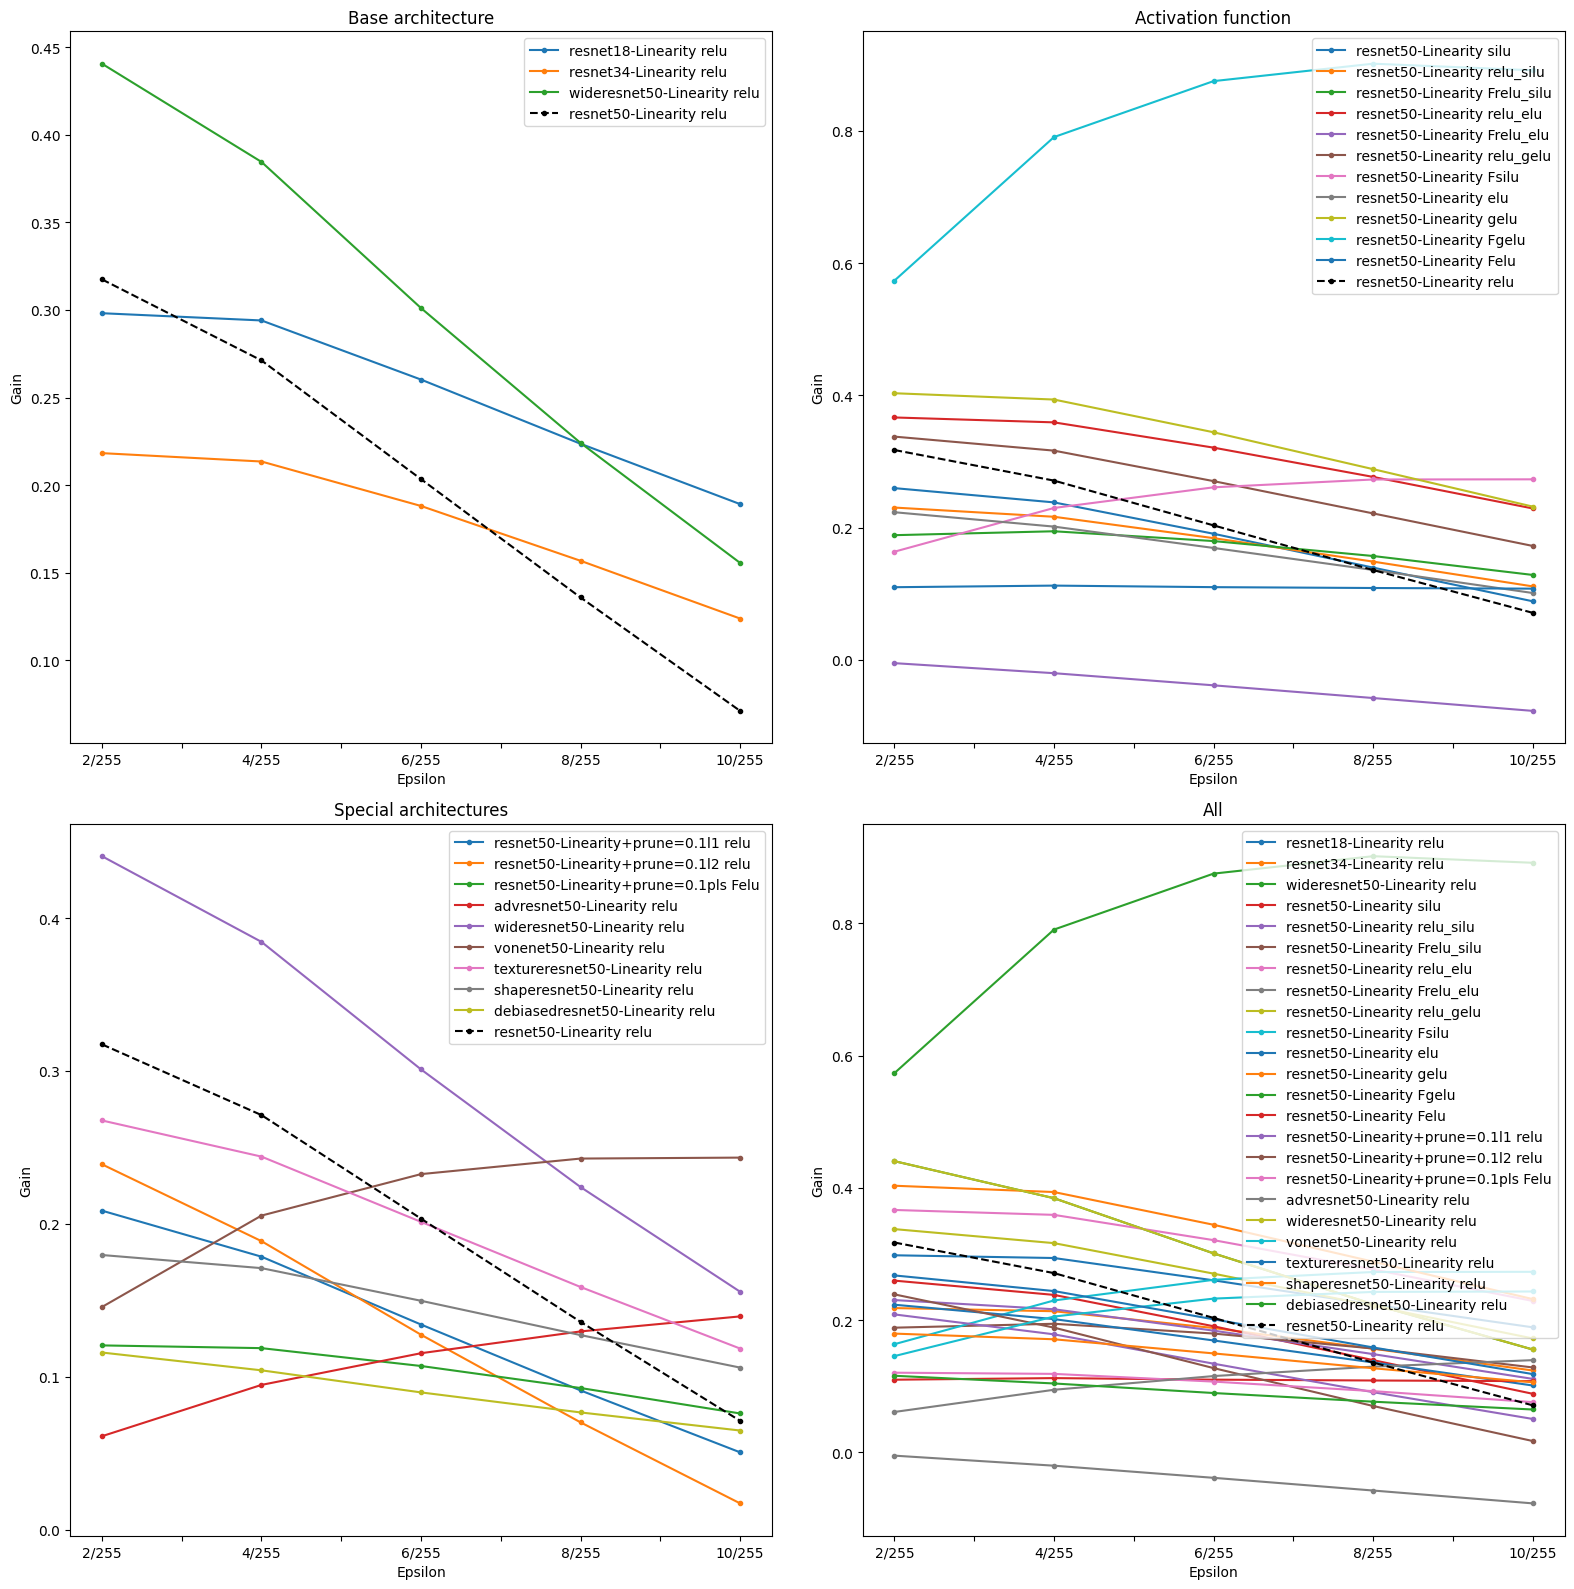

In [8]:
groups = [group_wd, group_activation, group_pruning+group_special, group_wd+group_activation+group_pruning+group_special]
epsilons = [2, 4, 6, 8, 10]
eps_labels = ['','2/255','','4/255','','6/255','','8/255','','10/255']
iters = 1.0

fig, axs = plt.subplots(2,2, figsize=(16,16), subplot_kw={"xticks": list(range(1,11)),"xticklabels": eps_labels, "xlabel": "Epsilon", "ylabel": "Gain"})

axs[0,0].set_title("Base architecture")
axs[0,1].set_title("Activation function")
axs[1,0].set_title("Special architectures")
axs[1,1].set_title("All")
fig.tight_layout()
axs  = axs.flatten()

for i in range(4):
    axis = axs[i]
    grp = groups[i]
    for arch, activ in grp:
        y_axis = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,f"eps {epsilons[0]}": f"eps {epsilons[-1]}"].values.tolist()[0]
        # if ((arch, activ) == baseline[0]):
        #     axis.plot(epsilons, y_axis,'k--', marker=".",label=f"{arch} {activ}")
        # else:
        if ((arch, activ) != baseline[0]):
            axis.plot(epsilons, y_axis, marker=".",label=f"{arch} {activ}")
    y_axis = data[(data["arch"]==baseline[0][0])&(data["iterations"]==iters)&(data["activation"]==baseline[0][1])].loc[:,f"eps {epsilons[0]}": f"eps {epsilons[-1]}"].values.tolist()[0]
    axis.plot(epsilons, y_axis,'k--', marker=".",label=f"{baseline[0][0]} {baseline[0][1]}")
    axis.legend(loc="upper right")

plt.show()

In [15]:
x = [2, 4, 6, 8, 10]
grp = set(group_wd+group_activation+group_pruning+group_special)
iters = [1, 3, 5]

df_pgd = pd.DataFrame(columns=['architecture', 'activation', 'SROCC','result_iter=1','result_iter=3','result_iter=5'])

for arch, activ in grp:
    y_axises = []
    for it in iters:
        # print(arch, activ)
        y_axis = data[(data["arch"]==arch)&(data["iterations"]==it)&(data["activation"]==activ)]\
            .loc[:,f"eps {epsilons[0]}": f"eps {epsilons[-1]}"].values.tolist()[0]
        y_axises.append(y_axis)
    srocc = data[(data["arch"]==arch)&(data["iterations"]==iters[0])&(data["activation"]==activ)].loc[:,"SROCC"].values.tolist()[0]
    df_pgd.loc[len(df_pgd)] = {
                                'architecture': arch, 
                                'activation': activ,
                                'SROCC': float(srocc),
                                'result_iter=1': (np.trapezoid(y_axises[0], x)),
                                'result_iter=3': (np.trapezoid(y_axises[1], x)),
                                'result_iter=5': (np.trapezoid(y_axises[2], x)),
                                # 'result_iter=8': (np.trapezoid(y_axises[3], x))
                                }
baseline_res_iter1 = df_pgd[(df_pgd['architecture']==baseline[0][0])&(df_pgd['activation']==baseline[0][1])]['result_iter=1'].values[0]
baseline_res_iter3 = df_pgd[(df_pgd['architecture']==baseline[0][0])&(df_pgd['activation']==baseline[0][1])]['result_iter=3'].values[0]
baseline_res_iter5 = df_pgd[(df_pgd['architecture']==baseline[0][0])&(df_pgd['activation']==baseline[0][1])]['result_iter=5'].values[0]


df_pgd['gain_iter=1'] = (baseline_res_iter1 - df_pgd['result_iter=1'])/baseline_res_iter1 *100
df_pgd['gain_iter=3'] = (baseline_res_iter3 - df_pgd['result_iter=3'])/baseline_res_iter3 *100
df_pgd['gain_iter=5'] = (baseline_res_iter5 - df_pgd['result_iter=5'])/baseline_res_iter5 *100

In [16]:
df_pgd.sort_values('result_iter=5').style.hide()

architecture,activation,SROCC,result_iter=1,result_iter=3,result_iter=5,gain_iter=1,gain_iter=3,gain_iter=5
resnet50-Linearity,Frelu_elu,0.852854,-0.314930,-0.315960,-0.350891,119.567019,106.630208,105.271857
resnet50-Linearity,Felu,0.836820,0.879594,1.492364,1.648105,45.349678,68.683717,75.238533
resnet50-Linearity+prune=0.1pls,Felu,0.842097,0.833254,1.637753,1.893518,48.228887,65.632830,71.551387
advresnet50-Linearity,relu,0.854453,0.879987,2.901547,3.935136,45.325293,39.112928,40.877697
resnet34-Linearity,relu,0.901809,1.458925,3.946982,4.711213,9.355139,17.175163,29.217765
debiasedresnet50-Linearity,relu,0.900750,0.721931,3.483180,5.272054,55.145498,26.907739,20.791560
resnet50-Linearity,elu,0.908697,1.338083,4.258631,5.625846,16.863214,10.635407,15.476123
resnet50-Linearity+prune=0.1l1,relu,0.906935,1.066691,4.570719,6.351996,33.725132,4.086465,4.566293
resnet50-Linearity,relu,0.907343,1.609495,4.765457,6.655925,0.000000,0.000000,0.000000
resnet50-Linearity+prune=0.1l2,relu,0.907126,1.028814,4.827336,6.803499,36.078481,-1.298487,-2.217188


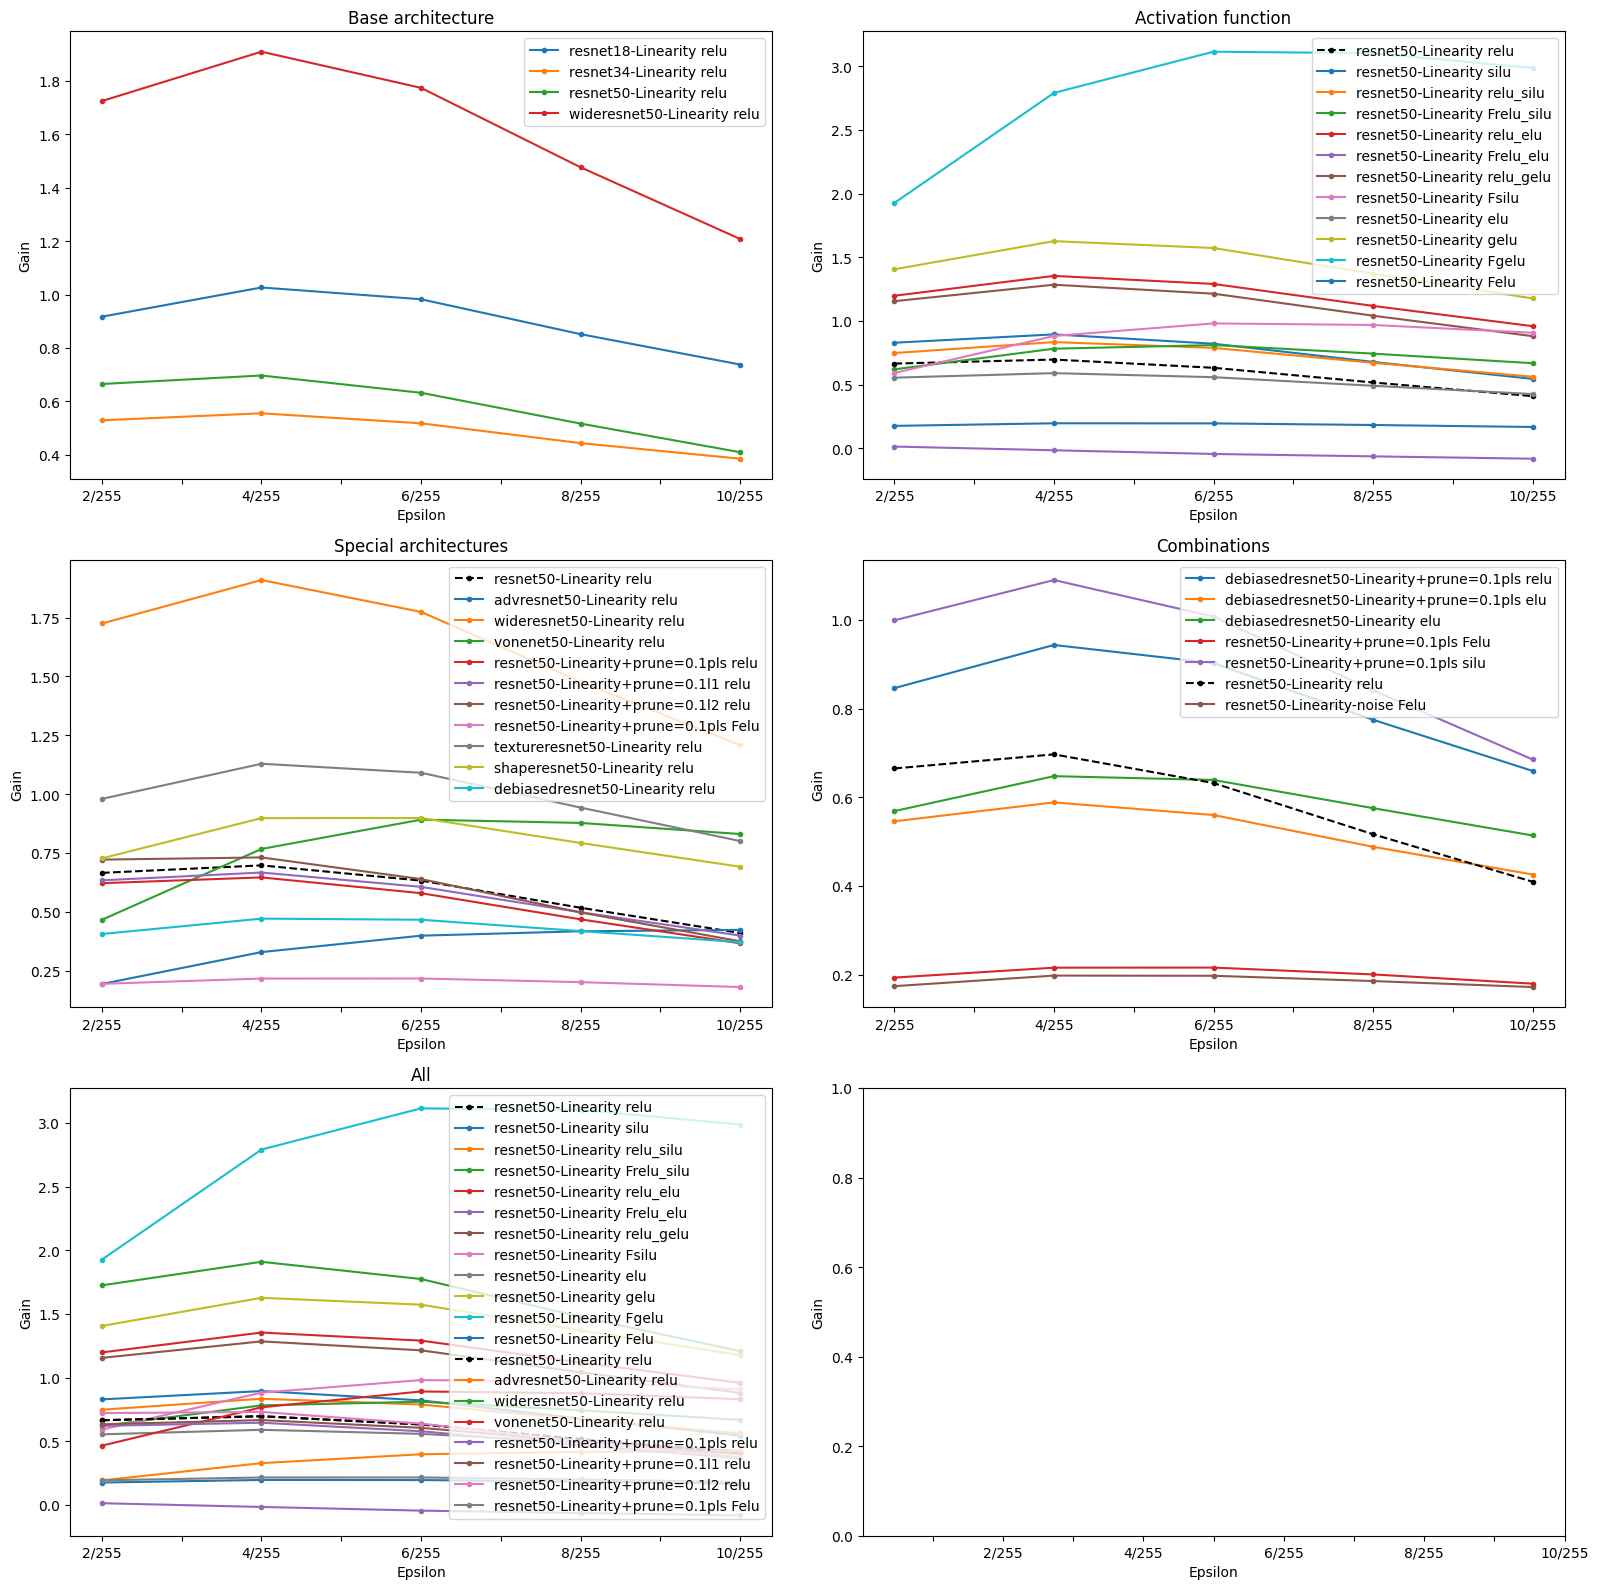

In [9]:
groups = [group_wd, group_activation, group_pruning+group_special, group_wd+group_activation+group_pruning+group_special]
epsilons = [2, 4, 6, 8, 10]
eps_labels = ['','2/255','','4/255','','6/255','','8/255','','10/255']
iters = 3.0

fig, axs = plt.subplots(2,2, figsize=(16,16), subplot_kw={"xticks": list(range(1,11)),"xticklabels": eps_labels, "xlabel": "Epsilon", "ylabel": "Gain"})

axs[0,0].set_title("Base architecture")
axs[0,1].set_title("Activation function")
axs[1,0].set_title("Special architectures")
axs[1,1].set_title("All")
fig.tight_layout()
axs  = axs.flatten()

for i in range(4):
    axis = axs[i]
    grp = groups[i]
    for arch, activ in grp:
        y_axis = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,f"eps {epsilons[0]}": f"eps {epsilons[-1]}"].values.tolist()[0]
        # if ((arch, activ) == baseline[0]):
        #     axis.plot(epsilons, y_axis,'k--', marker=".",label=f"{arch} {activ}")
        # else:
        if ((arch, activ) != baseline[0]):
            axis.plot(epsilons, y_axis, marker=".",label=f"{arch} {activ}")
    y_axis = data[(data["arch"]==baseline[0][0])&(data["iterations"]==iters)&(data["activation"]==baseline[0][1])].loc[:,f"eps {epsilons[0]}": f"eps {epsilons[-1]}"].values.tolist()[0]
    axis.plot(epsilons, y_axis,'k--', marker=".",label=f"{baseline[0][0]} {baseline[0][1]}")
    axis.legend(loc="upper right")

plt.show()

In [10]:
x = [2, 4, 6, 8, 10]
grp = set(group1+group2+group3+group4+group5)
iters = 3.0
df_ifgsm3_all_eps = pd.DataFrame(columns=['architecture', 'activation', 'SROCC','result'])
for arch, activ in grp:
    y_axis = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,f"eps {epsilons[0]}": f"eps {epsilons[-1]}"].values.tolist()[0]
    srocc = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,"SROCC"].values.tolist()[0]
    df_ifgsm3_all_eps.loc[len(df_ifgsm3_all_eps)] = {'architecture': arch, 
                       'activation': activ,
                       'SROCC': float(srocc),
                       'result': float((np.trapezoid(y_axis, x)))}
df_ifgsm3_all_eps.sort_values('result').style.hide()

architecture,activation,SROCC,result
resnet50-Linearity,Frelu_elu,0.852854,-0.315960
resnet50-Linearity,Felu,0.836820,1.492364
resnet50-Linearity-noise,Felu,0.828629,1.508366
resnet50-Linearity+prune=0.1pls,Felu,0.842097,1.637753
advresnet50-Linearity,relu,0.854453,2.901547
debiasedresnet50-Linearity,relu,0.900750,3.483180
resnet34-Linearity,relu,0.901809,3.946982
debiasedresnet50-Linearity+prune=0.1pls,elu,0.905012,4.245225
resnet50-Linearity,elu,0.908697,4.258631
resnet50-Linearity+prune=0.1pls,relu,0.905343,4.370357


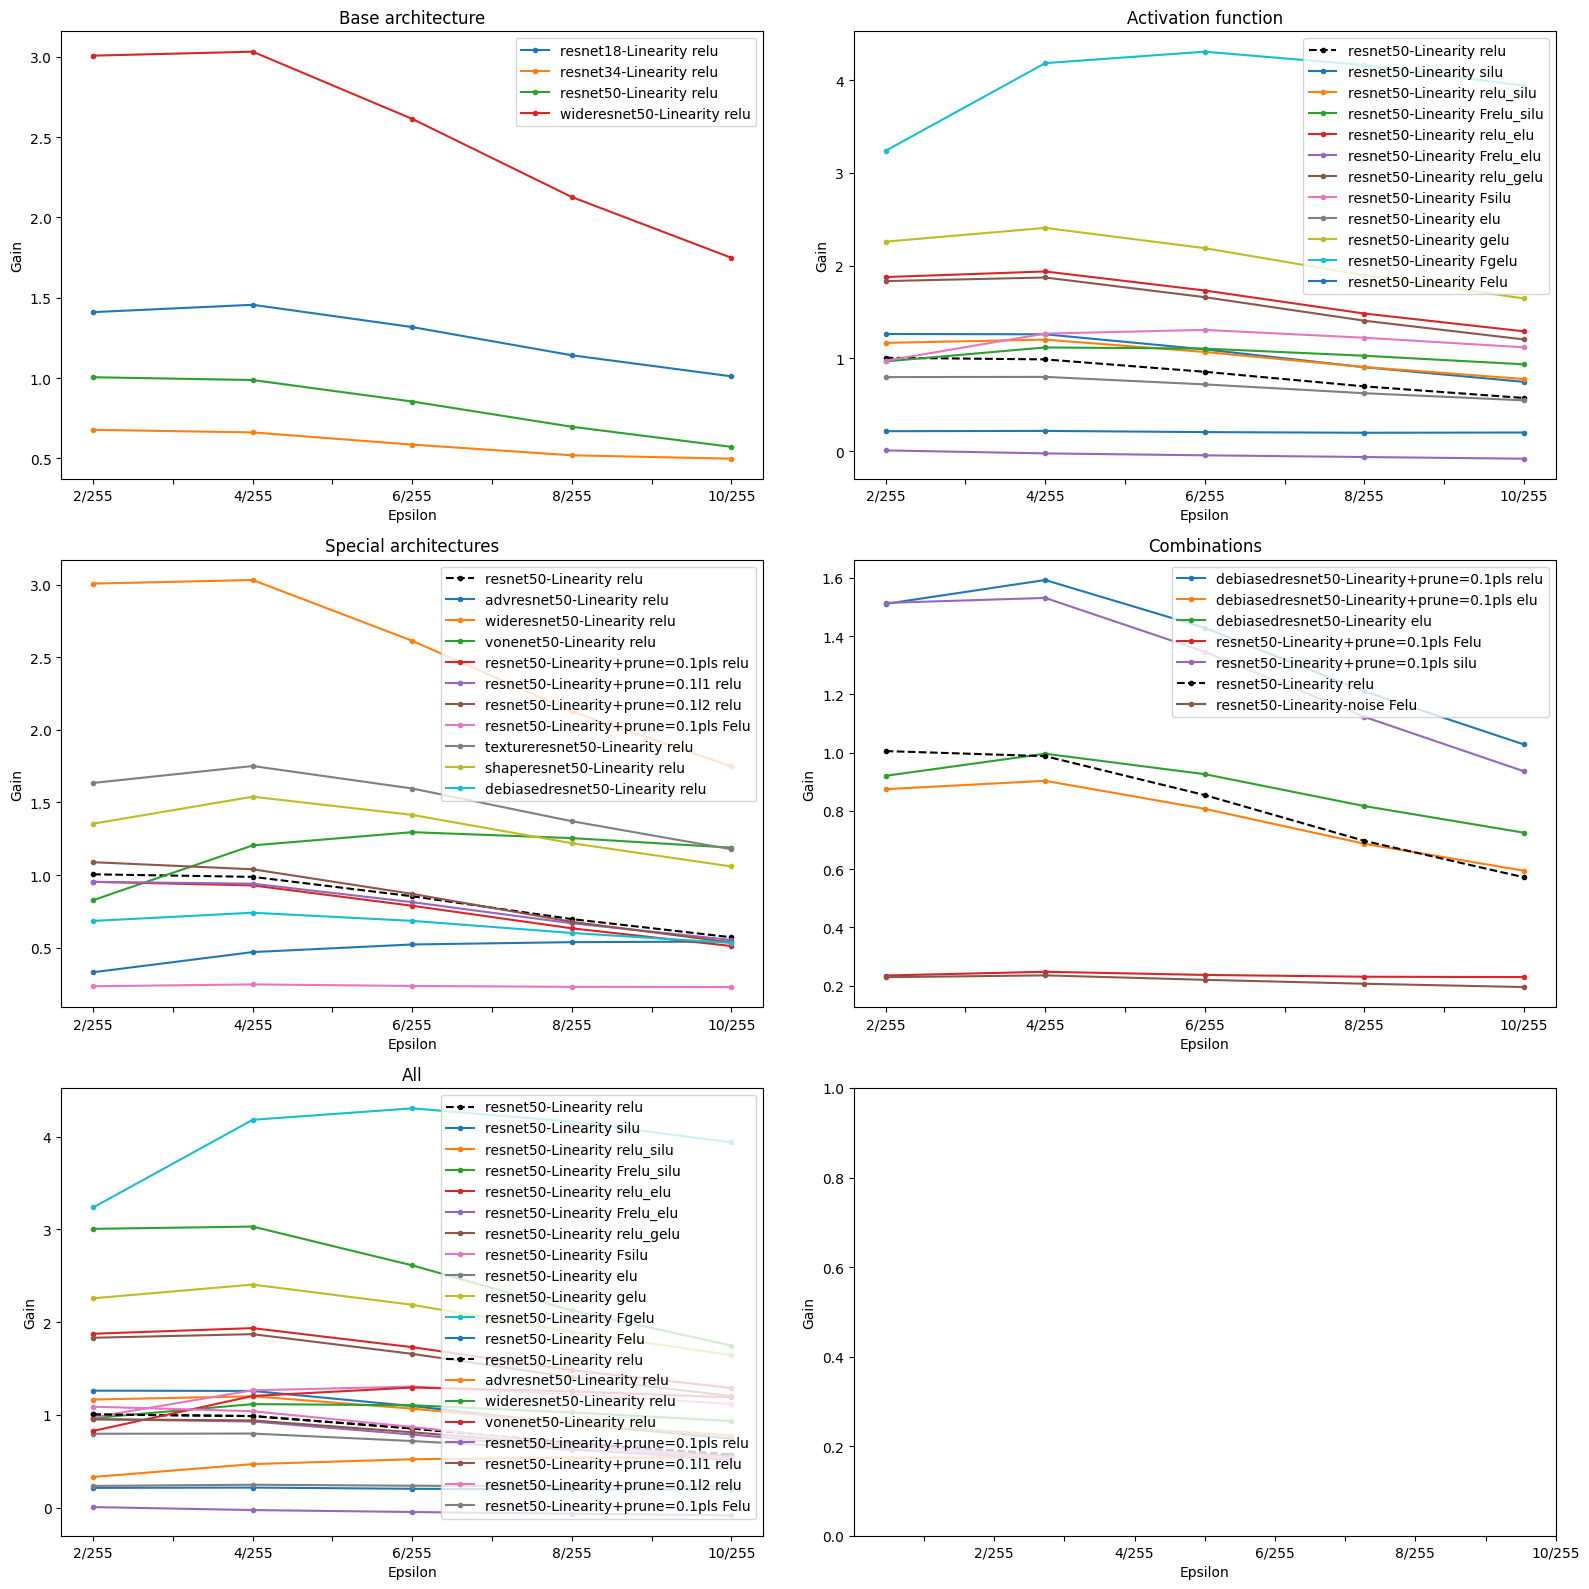

In [11]:
groups = [group_wd, group_activation, group_pruning+group_special, group_wd+group_activation+group_pruning+group_special]
epsilons = [2, 4, 6, 8, 10]
eps_labels = ['','2/255','','4/255','','6/255','','8/255','','10/255']
iters = 5.0

fig, axs = plt.subplots(2,2, figsize=(16,16), subplot_kw={"xticks": list(range(1,11)),"xticklabels": eps_labels, "xlabel": "Epsilon", "ylabel": "Gain"})

axs[0,0].set_title("Base architecture")
axs[0,1].set_title("Activation function")
axs[1,0].set_title("Special architectures")
axs[1,1].set_title("All")
fig.tight_layout()
axs  = axs.flatten()

for i in range(4):
    axis = axs[i]
    grp = groups[i]
    for arch, activ in grp:
        y_axis = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,f"eps {epsilons[0]}": f"eps {epsilons[-1]}"].values.tolist()[0]
        # if ((arch, activ) == baseline[0]):
        #     axis.plot(epsilons, y_axis,'k--', marker=".",label=f"{arch} {activ}")
        # else:
        if ((arch, activ) != baseline[0]):
            axis.plot(epsilons, y_axis, marker=".",label=f"{arch} {activ}")
    y_axis = data[(data["arch"]==baseline[0][0])&(data["iterations"]==iters)&(data["activation"]==baseline[0][1])].loc[:,f"eps {epsilons[0]}": f"eps {epsilons[-1]}"].values.tolist()[0]
    axis.plot(epsilons, y_axis,'k--', marker=".",label=f"{baseline[0][0]} {baseline[0][1]}")
    axis.legend(loc="upper right")

plt.show()

In [12]:
x = [2, 4, 6, 8, 10]
grp = set(group1+group2+group3+group4+group5)
iters = 5.0
df_ifgsm5_all_eps = pd.DataFrame(columns=['architecture', 'activation', 'SROCC','result'])
for arch, activ in grp:
    y_axis = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,f"eps {epsilons[0]}": f"eps {epsilons[-1]}"].values.tolist()[0]
    srocc = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,"SROCC"].values.tolist()[0]
    df_ifgsm5_all_eps.loc[len(df_ifgsm5_all_eps)] = {'architecture': arch, 
                       'activation': activ,
                       'SROCC': float(srocc),
                       'result': float(abs(np.trapezoid(y_axis, x)))}
df_ifgsm5_all_eps.sort_values('result').style.hide()

architecture,activation,SROCC,result
resnet50-Linearity,Frelu_elu,0.852854,0.350891
resnet50-Linearity,Felu,0.836820,1.648105
resnet50-Linearity-noise,Felu,0.828629,1.747023
resnet50-Linearity+prune=0.1pls,Felu,0.842097,1.893518
advresnet50-Linearity,relu,0.854453,3.935136
resnet34-Linearity,relu,0.901809,4.711213
debiasedresnet50-Linearity,relu,0.900750,5.272054
resnet50-Linearity,elu,0.908697,5.625846
resnet50-Linearity+prune=0.1pls,relu,0.905343,6.167884
debiasedresnet50-Linearity+prune=0.1pls,elu,0.905012,6.264514


In [13]:
x = [2, 4, 6]
grp = set(group1+group2+group3+group4+group5)
iters=1.0
df1 = pd.DataFrame(columns=['architecture', 'activation', 'SROCC','result'])
for arch, activ in grp:
    y_axis = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,f"eps {epsilons[0]}": f"eps {epsilons[2]}"].values.tolist()[0]
    srocc = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,"SROCC"].values.tolist()[0]
    df1.loc[len(df1)] = {'architecture': arch, 
                       'activation': activ,
                       'SROCC': float(format(srocc,'.2f')),
                       'result': float(format(np.trapezoid(y_axis, x), '.2f'))}
df1.sort_values('result').style.hide()

architecture,activation,SROCC,result
resnet50-Linearity,Frelu_elu,0.850000,-0.080000
resnet50-Linearity-noise,Felu,0.830000,0.300000
advresnet50-Linearity,relu,0.850000,0.370000
debiasedresnet50-Linearity,relu,0.900000,0.410000
resnet50-Linearity,Felu,0.840000,0.440000
resnet50-Linearity+prune=0.1pls,Felu,0.840000,0.460000
debiasedresnet50-Linearity+prune=0.1pls,elu,0.910000,0.640000
resnet50-Linearity+prune=0.1pls,relu,0.910000,0.660000
shaperesnet50-Linearity,relu,0.900000,0.670000
resnet50-Linearity+prune=0.1l1,relu,0.910000,0.700000


In [14]:
x = [6, 8, 10]
grp = set(group1+group2+group3+group4+group5)
iters = 1.0
df1 = pd.DataFrame(columns=['architecture', 'activation', 'SROCC','result'])
for arch, activ in grp:
    y_axis = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,f"eps {epsilons[2]}": f"eps {epsilons[-1]}"].values.tolist()[0]
    srocc = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,"SROCC"].values.tolist()[0]
    df1.loc[len(df1)] = {'architecture': arch, 
                       'activation': activ,
                       'SROCC': float(format(srocc,'.2f')),
                       'result': float(format(np.trapezoid(y_axis, x), '.2f'))}
df1.sort_values('result').style.hide()

architecture,activation,SROCC,result
resnet50-Linearity,Frelu_elu,0.850000,-0.230000
resnet50-Linearity-noise,Felu,0.830000,0.270000
resnet50-Linearity+prune=0.1l2,relu,0.910000,0.280000
resnet50-Linearity+prune=0.1pls,relu,0.910000,0.300000
debiasedresnet50-Linearity,relu,0.900000,0.310000
debiasedresnet50-Linearity+prune=0.1pls,relu,0.900000,0.360000
resnet50-Linearity+prune=0.1pls,Felu,0.840000,0.370000
resnet50-Linearity+prune=0.1l1,relu,0.910000,0.370000
debiasedresnet50-Linearity+prune=0.1pls,elu,0.910000,0.370000
resnet50-Linearity,Felu,0.840000,0.440000


In [15]:
x = [2, 4, 6]
grp = set(group1+group2+group3+group4+group5)
iters = 3.0
df1 = pd.DataFrame(columns=['architecture', 'activation', 'SROCC','result'])
for arch, activ in grp:
    y_axis = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,f"eps {epsilons[0]}": f"eps {epsilons[2]}"].values.tolist()[0]
    srocc = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,"SROCC"].values.tolist()[0]
    df1.loc[len(df1)] = {'architecture': arch, 
                       'activation': activ,
                       'SROCC': float(format(srocc,'.2f')),
                       'result': float(format(np.trapezoid(y_axis, x), '.2f'))}
df1.sort_values('result').style.hide()

architecture,activation,SROCC,result
resnet50-Linearity,Frelu_elu,0.850000,-0.060000
resnet50-Linearity,Felu,0.840000,0.760000
resnet50-Linearity-noise,Felu,0.830000,0.770000
resnet50-Linearity+prune=0.1pls,Felu,0.840000,0.840000
advresnet50-Linearity,relu,0.850000,1.250000
debiasedresnet50-Linearity,relu,0.900000,1.810000
resnet34-Linearity,relu,0.900000,2.160000
debiasedresnet50-Linearity+prune=0.1pls,elu,0.910000,2.280000
resnet50-Linearity,elu,0.910000,2.290000
resnet50-Linearity+prune=0.1pls,relu,0.910000,2.490000


In [16]:
x = [6, 8, 10]
grp = set(group1+group2+group3+group4+group5)
iters = 3.0
df1 = pd.DataFrame(columns=['architecture', 'activation', 'SROCC','result'])
for arch, activ in grp:
    y_axis = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,f"eps {epsilons[2]}": f"eps {epsilons[-1]}"].values.tolist()[0]
    srocc = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,"SROCC"].values.tolist()[0]
    df1.loc[len(df1)] = {'architecture': arch, 
                       'activation': activ,
                       'SROCC': float(format(srocc,'.2f')),
                       'result': float(format(np.trapezoid(y_axis, x), '.2f'))}
df1.sort_values('result').style.hide()

architecture,activation,SROCC,result
resnet50-Linearity,Frelu_elu,0.850000,-0.250000
resnet50-Linearity,Felu,0.840000,0.730000
resnet50-Linearity-noise,Felu,0.830000,0.740000
resnet50-Linearity+prune=0.1pls,Felu,0.840000,0.800000
advresnet50-Linearity,relu,0.850000,1.650000
debiasedresnet50-Linearity,relu,0.900000,1.670000
resnet34-Linearity,relu,0.900000,1.790000
resnet50-Linearity+prune=0.1pls,relu,0.910000,1.880000
debiasedresnet50-Linearity+prune=0.1pls,elu,0.910000,1.960000
resnet50-Linearity,elu,0.910000,1.970000


In [17]:
x = [2, 4, 6]
grp = set(group1+group2+group3+group4+group5)
iters = 5.0
df1 = pd.DataFrame(columns=['architecture', 'activation', 'SROCC','result'])
for arch, activ in grp:
    y_axis = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,f"eps {epsilons[0]}": f"eps {epsilons[2]}"].values.tolist()[0]
    srocc = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,"SROCC"].values.tolist()[0]
    df1.loc[len(df1)] = {'architecture': arch, 
                       'activation': activ,
                       'SROCC': float(format(srocc,'.2f')),
                       'result': float(format(np.trapezoid(y_axis, x), '.2f'))}
df1.sort_values('result').style.hide()

architecture,activation,SROCC,result
resnet50-Linearity,Frelu_elu,0.850000,-0.090000
resnet50-Linearity,Felu,0.840000,0.850000
resnet50-Linearity-noise,Felu,0.830000,0.920000
resnet50-Linearity+prune=0.1pls,Felu,0.840000,0.970000
advresnet50-Linearity,relu,0.850000,1.790000
resnet34-Linearity,relu,0.900000,2.590000
debiasedresnet50-Linearity,relu,0.900000,2.850000
resnet50-Linearity,elu,0.910000,3.110000
debiasedresnet50-Linearity+prune=0.1pls,elu,0.910000,3.490000
resnet50-Linearity+prune=0.1pls,relu,0.910000,3.600000


In [18]:
x = [6, 8, 10]
grp = set(group1+group2+group3+group4+group5)
iters = 5.0
df1 = pd.DataFrame(columns=['architecture', 'activation', 'SROCC','result'])
for arch, activ in grp:
    y_axis = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,f"eps {epsilons[2]}": f"eps {epsilons[-1]}"].values.tolist()[0]
    srocc = data[(data["arch"]==arch)&(data["iterations"]==iters)&(data["activation"]==activ)].loc[:,"SROCC"].values.tolist()[0]
    df1.loc[len(df1)] = {'architecture': arch, 
                       'activation': activ,
                       'SROCC': float(format(srocc,'.2f')),
                       'result': float(format(np.trapezoid(y_axis, x), '.2f'))}
df1.sort_values('result').style.hide()

architecture,activation,SROCC,result
resnet50-Linearity,Frelu_elu,0.850000,-0.260000
resnet50-Linearity,Felu,0.840000,0.800000
resnet50-Linearity-noise,Felu,0.830000,0.830000
resnet50-Linearity+prune=0.1pls,Felu,0.840000,0.930000
resnet34-Linearity,relu,0.900000,2.120000
advresnet50-Linearity,relu,0.850000,2.140000
debiasedresnet50-Linearity,relu,0.900000,2.420000
resnet50-Linearity,elu,0.910000,2.510000
resnet50-Linearity+prune=0.1pls,relu,0.910000,2.570000
resnet50-Linearity+prune=0.1l1,relu,0.910000,2.700000


In [19]:
baseline = [('resnet50-Linearity', 'relu')]
group_activation = [('resnet50-Linearity', 'relu'),
                    ("resnet50-Linearity", "silu"), 
                    ("resnet50-Linearity", "relu_silu"),
                    ("resnet50-Linearity", "Frelu_silu"),
                    ("resnet50-Linearity", "relu_elu"),
                    ("resnet50-Linearity", "Frelu_elu"),
                    ("resnet50-Linearity", "relu_gelu"),
                    ("resnet50-Linearity", "Fsilu"),
                    ("resnet50-Linearity", "elu"),
                    ("resnet50-Linearity", "gelu"),
                    ("resnet50-Linearity", "Fgelu"),("resnet50-Linearity", "Felu") ]
group_wd = [("resnet18-Linearity", "relu"), 
            ("resnet34-Linearity", "relu"), 
            ('resnet50-Linearity', 'relu'),
            ("wideresnet50-Linearity", "relu")]
group_pruning = [("resnet50-Linearity+prune=0.1pls", "relu"),
                 ("resnet50-Linearity+prune=0.1l1", "relu"),
                 ("resnet50-Linearity+prune=0.1l2", "relu")]

group_feature_ex = [("textureresnet50-Linearity","relu"), ("shaperesnet50-Linearity","relu"), ("debiasedresnet50-Linearity","relu")]
group_special = [("advresnet50-Linearity","relu"),("vonenet50-Linearity", "relu")] + group_feature_ex
group_combinatioins = [("debiasedresnet50-Linearity+prune=0.1pls", "relu"), 
                       ("debiasedresnet50-Linearity+prune=0.1pls", "elu"), 
                       ("debiasedresnet50-Linearity", "elu"), 
                       ("resnet50-Linearity+prune=0.1pls", "Felu"), 
                       ("resnet50-Linearity+prune=0.1pls", "silu"),
                       ("resnet50-Linearity-noise", "Felu")
                       ]

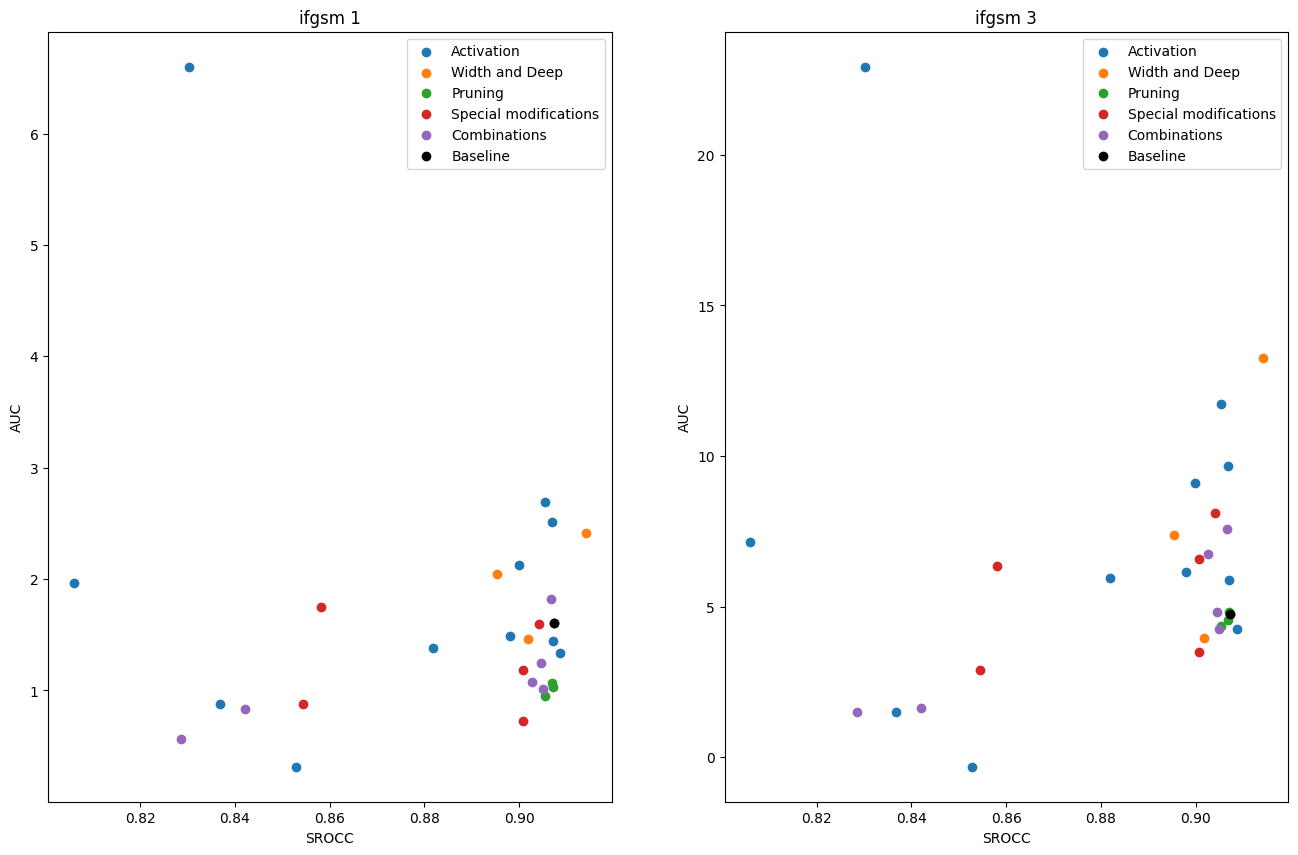

In [28]:
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(40)

types = [group_activation, group_wd, group_pruning, group_special, group_combinatioins]
labels = ["Activation", "Width and Deep", "Pruning", "Special modifications", "Combinations"]
df_ifgsm_iter = [df_ifgsm1_all_eps, df_ifgsm3_all_eps, df_ifgsm5_all_eps]
fig, ax = plt.subplots(1,2, figsize=(16,10))
ax = ax.flatten()

for axis in ax:
    axis.set_xlabel('SROCC')
    axis.set_ylabel('AUC')

for i in range(len(df_ifgsm_iter[:2])):
    axis = ax[i]
    axis.set_title(f"ifgsm {1+2*i}")
    df_ifgsm = df_ifgsm_iter[i]
    for j, type_ in enumerate(types):
        type_df = pd.DataFrame(columns=['architecture','activation','SROCC','result'])
        label = labels[j]
        for arch, activ in type_:
            type_df = pd.concat([type_df, df_ifgsm[(df_ifgsm['architecture']==arch)&(df_ifgsm['activation']==activ)]], ignore_index=True)
        axis.scatter(type_df['SROCC'], type_df['result'], label=label)
    df_baseline = df_ifgsm[(df_ifgsm['architecture']=='resnet50-Linearity')&(df_ifgsm['activation']=='relu')]
    axis.scatter(df_baseline['SROCC'], df_baseline['result'], color='black', label="Baseline")
    axis.legend()

# axis = ax[-1]
# all_types = list(set(group_activation+group_combinatioins+group_special+group_pruning+group_wd))
# color = 0x1
# for arch, activ in all_types:
#     df = pd.DataFrame(columns=['architecture','activation','SROCC','result'])
#     for df_ifgsm in df_ifgsm_iter:
#         df = pd.concat([df, df_ifgsm[(df_ifgsm['architecture']==arch)&(df_ifgsm['activation']==activ)]], ignore_index=True)
#     color *= random.randrange(0x1, 0xfffff)
#     color += random.randrange(0x0, 0xfffff)
#     color &= 0xffffff
#     axis.plot(df['SROCC'], df['result'], '^--',color=f'#{color:06X}', label=arch+'_'+activ)

# df = pd.DataFrame(columns=['architecture','activation','SROCC','result'])
# for df_ifgsm in df_ifgsm_iter:
#     df = pd.concat([df, df_ifgsm[(df_ifgsm['architecture']=='resnet50-Linearity')&(df_ifgsm['activation']=='relu')]], ignore_index=True)
# axis.plot(df['SROCC'], df['result'], '^--', color='#000000',label='resnet50-Linearity_relu')
# axis.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)

plt.show()
fig.savefig('scatter_types.png')

[209.5267201258625, 209.5267201258625, 209.5267201258625, 334.03281729188336, 334.03281729188336, 334.03281729188336, 893.5238825426171, 893.5238825426171, 893.5238825426171, 911.6372384285982, 911.6372384285982, 911.6372384285982, 915.6461898490352, 915.6461898490352, 915.6461898490352, 931.2017113255354, 931.2017113255354, 931.2017113255354]
[<matplotlib.lines.Line2D object at 0x7fcd19345910>, <matplotlib.lines.Line2D object at 0x7fcd184744a0>, <matplotlib.lines.Line2D object at 0x7fcd1934d040>] ['0.81', '0.89', '0.91']


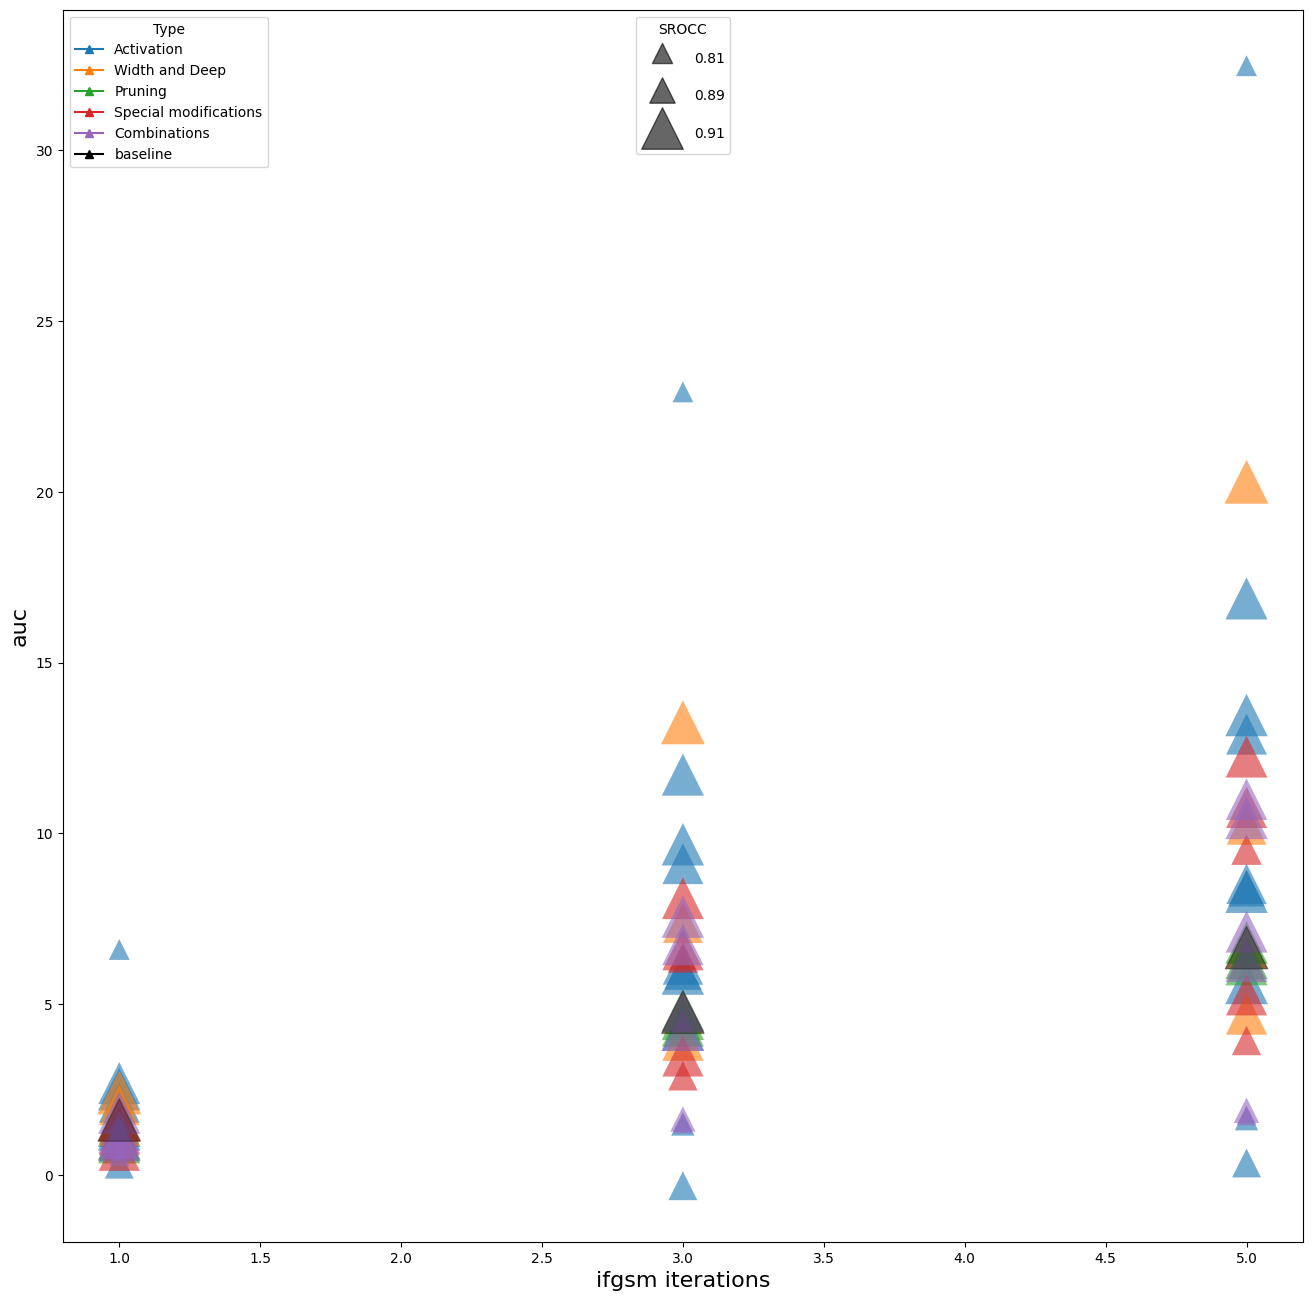

In [94]:
from sklearn.preprocessing import StandardScaler
types = [group_activation, group_wd, group_pruning, group_special, group_combinatioins]
labels = ["Activation", "Width and Deep", "Pruning", "Special modifications", "Combinations"]
df_ifgsm_iter = [df_ifgsm1_all_eps, df_ifgsm3_all_eps, df_ifgsm5_all_eps]
fig, axis = plt.subplots( figsize=(16,16))
# ax = ax.flatten()
# df_activation =  pd.DataFrame(columns=['architecture','activation','SROCC','result', 'ifgsm'])
cols = ['architecture','activation','SROCC','result', 'ifgsm']
dfs = {"Activation": pd.DataFrame(columns=cols),
       "Width and Deep": pd.DataFrame(columns=cols),
       "Pruning":pd.DataFrame(columns=cols),
       "Special modifications":pd.DataFrame(columns=cols),
       "Combinations":pd.DataFrame(columns=cols)
      }

for j, type_ in enumerate(types):
    label = labels[j]
    for i in range(len(df_ifgsm_iter)):
        df_ifgsm = df_ifgsm_iter[i]
        # df =dfs[label]
        for arch, activ in type_:
            tmp = df_ifgsm[(df_ifgsm['architecture']==arch)&(df_ifgsm['activation']==activ)]
            tmp['ifgsm'] = 1+2*i
            dfs[label].loc[len(dfs[label])] = tmp.values[0]
        # print(dfs[label])

srocc_min = df_ifgsm1_all_eps['SROCC'].min()
srocc_max = df_ifgsm1_all_eps['SROCC'].max()
srocc_mean = df_ifgsm1_all_eps['SROCC'].mean()
srocc_std = df_ifgsm1_all_eps['SROCC'].std()
scale = {}

for key in dfs.keys():
    tmp = (dfs[key]['SROCC'] - srocc_min)/(srocc_max-srocc_min) * 1000
    # tmp = (dfs[key]['SROCC'] - srocc_mean)/srocc_std * 1000
    # tmp = dfs[key]['SROCC']
    scale[key] = tmp.values.tolist()

a = 0.6
legend_colors = []
legend_labels = []
for key, df in dfs.items():
    scatter = axis.scatter(df['ifgsm'], df['result'], label=key, s=scale[key], alpha=a, marker='^', edgecolors='none')
print(sorted(scale['Combinations']))
# sk_srocc = list(map(lambda x: f'{x/1000 * srocc_std + srocc_mean:.2f}',sorted(scale['Combinations'])[0::3]))
sk_srocc = [f'{srocc_min:.2f}', f'{srocc_mean:.2f}', f'{srocc_max:.2f}']
handles_legend, labels_legend = scatter.legend_elements(prop='sizes', alpha=0.6)
labels_legend = sk_srocc
handles_legend = handles_legend[:3]
print(handles_legend, labels_legend)


baseline = pd.concat(
      [df_ifgsm1_all_eps[(df_ifgsm['architecture']=='resnet50-Linearity')&(df_ifgsm['activation']=='relu')],
       df_ifgsm3_all_eps[(df_ifgsm['architecture']=='resnet50-Linearity')&(df_ifgsm['activation']=='relu')],
       df_ifgsm5_all_eps[(df_ifgsm['architecture']=='resnet50-Linearity')&(df_ifgsm['activation']=='relu')]], ignore_index=True)
baseline['ifgsm'] = [1,3,5]
baseline_srocc = df_ifgsm1_all_eps[(df_ifgsm['architecture']=='resnet50-Linearity')&(df_ifgsm['activation']=='relu')]['SROCC']
baseline_s = (baseline_srocc - srocc_min)/(srocc_max-srocc_min) * 1000
baseline_scale = [baseline_s] * len(baseline['ifgsm'])
scatter = axis.scatter(baseline['ifgsm'], baseline['result'], label='baseline', s=baseline_scale, c='black', alpha=0.3, marker='^')

axis.set_xlabel('ifgsm iterations', fontsize=16)
axis.set_ylabel('auc', fontsize=16)

# legend1 = axis.legend(handles=handles, labels=labels, loc='upper left', title='Type')
legend1 = axis.legend(handles=[plt.plot([],marker='^')[0] for _ in range(len(labels))] + [plt.plot([],marker='^',color='black')[0]],
                      labels=labels+['baseline'], 
                      loc='upper left', title='Type')
axis.add_artist(legend1)
# handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = axis.legend(handles_legend, labels_legend, loc="upper center", title="SROCC", handleheight=3, handlelength=3)

plt.show()
fig.savefig('graph_types.png')